# Analysis of French first names between 1900 and 2015

USING INSEE FILES AVAILABLE AT: https://www.insee.fr/fr/statistiques/2540004#consulter

## Content:

1. Import and prepare the dataset
2. Most common names in 2015 and overall between 1900 and 2015
3. Trend of some specific names throughout the years
4. Evolution of the number of names
5. Name trends
6. Evolution of the length of names

## 1. Import and prepare the dataset

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import ngrams

### Import the dataset

In [2]:
df = pd.read_csv('nat2015.txt', sep = '\t', encoding = 'latin1')
print(df.head())

# Alternatively, can use Excel to convert the txt file into csv format 
# use the tab delimiter and 1252: Western European (Windows) (to properly display the French characters (é, ï, etc.)).

   sexe preusuel annais  nombre
0     1        A   1980     3.0
1     1        A   1998     3.0
2     1        A   XXXX    21.0
3     1    AADEL   1976     5.0
4     1    AADEL   1978     3.0


### Presentation of the features

The file contains four features:
- 'sexe': 1 for male, 2 for female
- 'preusuel': first name
- 'annais': year of birth, between 1900 and 2015
- 'nombre': number of people that year with that first name

INSEE used the following criteria to include a name or not:
1. Between 1900 and 1945, the name has been given at least 20 times to females and/or at least 20 times to males.
2. Between 1946 and 2015, the name has been given at least 20 times to females and/or at least 20 times to males.
3. For a given year, the name has been given at least 3 times to females or males.

Names that do not comply with conditions 1 and 2 are grouped by sex and year of birth under one entry with the value 'PRENOMS_RARES' (rare names) in the 'preusuel' column.

Names that comply with condition 2 but not condition 3 are grouped by sex and name under one entry with the value 'XXXX' in the 'annais' column.

### Rename columns

In [3]:
df.columns = ['sex', 'name', 'year', 'number']
print(df.head())

   sex   name  year  number
0    1      A  1980     3.0
1    1      A  1998     3.0
2    1      A  XXXX    21.0
3    1  AADEL  1976     5.0
4    1  AADEL  1978     3.0


### Example with the first name 'A'

In [4]:
dfA = df[(df.name) == 'A']
print(dfA)

   sex name  year  number
0    1    A  1980     3.0
1    1    A  1998     3.0
2    1    A  XXXX    21.0


- The first name 'A' was given 3 times to males in 1980.
- The first name 'A' was given 3 times to males in 1998.
- The first name 'A' was given 21 times between 1946 and 2015 but never more than 3 times for a given year except in 1980 and 1998.

### General characteristics of the dataset

There are 589,411 entries (rows) in the dataset, corresponding to almost 83 million people, and over 31,000 names.

The gender ('sex') and number of people ('number') are considered integers.

The names ('name') and year ('year') are considered objects (strings). Years are considered strings because they include 'XXXX' values.

In [5]:
df.info(memory_usage="deep")

# Alternative way to get info:
# print(len(df.index), df.sex.dtype, df.name.dtype, df.year.dtype, df.number.dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589411 entries, 0 to 589410
Data columns (total 4 columns):
sex       589411 non-null int64
name      589408 non-null object
year      589411 non-null object
number    589411 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 79.9 MB


Note: There are 3 null entries in the 'name' column.

In [6]:
dfnull = df[pd.isnull(df.name)]
print(dfnull)

        sex name  year  number
497244    2  NaN  1982     3.0
497245    2  NaN  2003     3.0
497246    2  NaN  XXXX    22.0


### Convert 'sex' column from integers to Boolean

Convert 'sex' column from integers (1 and 2) to Boolean (False for male and True for female)

In [7]:
d = {1: False, 2: True}
df.sex = df.sex.apply(lambda x: d[x])

print(df.head())
print("Type of 'sex' column: " + str(df.sex.dtype))

     sex   name  year  number
0  False      A  1980     3.0
1  False      A  1998     3.0
2  False      A  XXXX    21.0
3  False  AADEL  1976     5.0
4  False  AADEL  1978     3.0
Type of 'sex' column: bool


### Convert 'year' column from objects (strings) to float

#### Method 1
Replace the 'XXXX' values in the 'year' column with 0, then convert to integer.

Note 1: When replacing 'XXXX' by 0 (instead of NaN), need to exclude 0 from the x-axis in graphs ([1900,2015] vs. [0,2015]). 

Note 2: Without using pd.to_numeric, get int32 instead of int16 (which takes more memory).

In [8]:
# df.year = df.year.replace('XXXX', 0)
# df.year = df.year.astype('int')
# df.year = pd.to_numeric(df.year, errors = 'coerce', downcast = 'integer')

#### Method 2

Change the type of 'year' to numeric with the pd.to_numeric() function

Use errors = 'coerce' to set invalid entries (such as 'XXXX') as NaN.

Note: Get Float32 (not integer, even with 'downcast = 'integer') because of NaN values.

'The lack of NaN rep in integer columns is a pandas "gotcha".'

http://stackoverflow.com/questions/21287624/convert-pandas-column-containing-nans-to-dtype-int

In [9]:
df.year = pd.to_numeric(df.year, errors = 'coerce', downcast = 'float')

print(df.head())
print("Type of 'year' column: " + str(df.year.dtype))

     sex   name    year  number
0  False      A  1980.0     3.0
1  False      A  1998.0     3.0
2  False      A     NaN    21.0
3  False  AADEL  1976.0     5.0
4  False  AADEL  1978.0     3.0
Type of 'year' column: float32


### Convert 'number' column from float64 to in32

In [10]:
nb_max = df.number.max()
int8_max = np.iinfo("int8").max
int16_max = np.iinfo("int16").max
int32_max = np.iinfo("int32").max

df.number = pd.to_numeric(df.number, errors = 'coerce', downcast = 'integer')
nb_type = df.number.dtype

print('Maximum value in the "number" column: {0:.0f} \
      \nOutput range of int 8: {1} \
      \nOutput range of int 16: {2} \
      \nOutput range of int 32: {3}\
      \nType of "number" column: {4}'.format(nb_max, int8_max, int16_max, int32_max, nb_type))

Maximum value in the "number" column: 53897       
Output range of int 8: 127       
Output range of int 16: 32767       
Output range of int 32: 2147483647      
Type of "number" column: int32


#### Note: The memory usage went down, from 80 MB to 42 MB.

In [11]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589411 entries, 0 to 589410
Data columns (total 4 columns):
sex       589411 non-null bool
name      589408 non-null object
year      557017 non-null float32
number    589411 non-null int32
dtypes: bool(1), float32(1), int32(1), object(1)
memory usage: 41.7 MB


### Number of births

#### Total number of births between 1900 and 2015

The file contains data on almost 83 million people. 

This reflects the total number of births in France between 1900 and 2015 (about 500,000 births/year in 1900-1945, and 800,000 births/year in 1946-2015).

There might be some discrepancies with the actual number of births estimated by INSEE, especially for years prior to 1946.

In [12]:
tot_pop = df.number.sum()
tot_male = df[df.sex == 0].number.sum()
tot_female = df[df.sex == 1].number.sum()

print('The file contains data on about {0:.0f} people including {1:.0f} males and {2:.0f} females.'\
      .format(tot_pop, tot_male, tot_female))

The file contains data on about 82860682 people including 41722777 males and 41137905 females.


#### Number of births per year (total)
We can easily notice on the graph:
- the dip in the number of births during WWI, from 548,000 in 1913 down to 283,000 in 1916 (-48% in 3 years)!
- the dip in the number of births during WWII
- the baby boom after WWII, from 592,000 in 1945 up to 893,000 in 1947 (+51% in 2 years)!

Number of births in 1913: 548028
Number of births in 1916: 282807
Number of births in 1945: 591774
Number of births in 1947: 892941


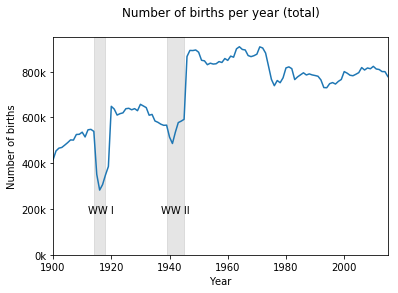

In [13]:
annual_births_series = df.groupby(['year'])['number'].sum()

fig, ax = plt.subplots()

for year in sorted({1913, 1916, 1945, 1947}):
    print('Number of births in ' + str(year) + ': ' + str(annual_births_series[year]))

annual_births_series.plot(kind='line', title = 'Number of births per year (total)\n')
plt.xlim([1900,2015])
plt.ylim([0,950000])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,}k'.format(int(x/1000)) for x in vals])
plt.xlabel('Year')
plt.ylabel('Number of births')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 180000))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1937, 180000))
plt.show()

#### Number of births per year (male and female)

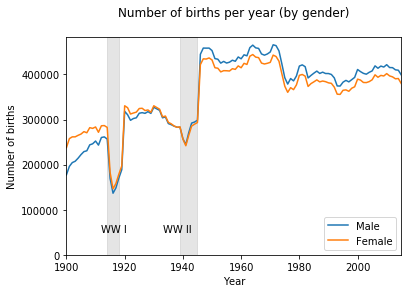

In [14]:
df_M = df[df.sex == 0]
df_F = df[df.sex == 1]

annual_births_seriesM = df_M.groupby(['year'])['number'].sum()
annual_births_seriesF = df_F.groupby(['year'])['number'].sum()

plt.plot(annual_births_seriesM, label = 'Male')
plt.plot(annual_births_seriesF, label = 'Female')
plt.title('Number of births per year (by gender)\n')
plt.legend(loc = 'lower right')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.xlabel('Year')
plt.ylabel('Number of births')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 50000))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1933, 50000))
plt.show()

#### Calculating the percentage of total births each name represent each year

In order to eliminate the effects of demography on the trend of names, let's calculate for each year the percentage of total births of the same gender each name represent.

In [15]:
# Number of annual births per gender
df_M = df[df.sex == 0].copy()
df_F = df[df.sex == 1].copy()

annual_births_seriesM = df_M.groupby(['year'])['number'].sum()
annual_births_seriesF = df_F.groupby(['year'])['number'].sum()

# Convert series to dataframe
annual_births = annual_births_series.to_frame(name='annual_births')
annual_births_M = annual_births_seriesM.to_frame(name='annual_births_M')
annual_births_F = annual_births_seriesF.to_frame(name='annual_births_F')

# Merge the dataframes with a left join
df = df.join(annual_births, on = 'year', how = 'left')
df = df.join(annual_births_M, on = 'year', how = 'left')
df = df.join(annual_births_F, on = 'year', how = 'left')

# Calculate the percentage of births each name represent
df['ratio'] = df.number / df.annual_births * 100
df['ratio_M'] = df.number / df.annual_births_M * 100
df['ratio_F'] = df.number / df.annual_births_F * 100

print(df.head(5))

     sex   name    year  number  annual_births  annual_births_M  \
0  False      A  1980.0       3       816506.0         418525.0   
1  False      A  1998.0       3       757799.0         388410.0   
2  False      A     NaN      21            NaN              NaN   
3  False  AADEL  1976.0       5       738866.0         378608.0   
4  False  AADEL  1978.0       3       751882.0         385663.0   

   annual_births_F     ratio   ratio_M   ratio_F  
0         397981.0  0.000367  0.000717  0.000754  
1         369389.0  0.000396  0.000772  0.000812  
2              NaN       NaN       NaN       NaN  
3         360258.0  0.000677  0.001321  0.001388  
4         366219.0  0.000399  0.000778  0.000819  


#### Number of different names between 1900 and 2015

In [16]:
print('Total number of different names between 1900 and 2015: {}'.format(df.name.nunique()))

Total number of different names between 1900 and 2015: 31047


### Create 3 separate dataframes

- df: Dataframe with 'regular' names
- df_rare: Dataframe with 'rare' names (_PRENOMS_RARES), that is less than 20 people between 1900-1945 and 1946-2015
- df_xxxx: Dataframe with 'unspecified' years (year == 'XXXX'), that is less than 3 people in a given year

#### Dataframe of names with 'unspecified' year only (df_xxxx)

In [17]:
# Create dataframe with 'unspecified' years only
df_xxxx = df[df.year.isnull()].copy()

# Delete the 'annual_births' and 'ratio' columns since they are empty (cannot calculate with unspecified year)
del df_xxxx['annual_births']
del df_xxxx['ratio']

print(df_xxxx.head())
print('Number of unique names (unspecified years): ' + str(df_xxxx.name.nunique()))
print('Number of people (unspecified years): {0} ({1}% of total births)'\
      .format((df_xxxx.number.sum()), round((df_xxxx.number.sum() / tot_pop), 2)))

      sex    name  year  number  annual_births_M  annual_births_F  ratio_M  \
2   False       A   NaN      21              NaN              NaN      NaN   
10  False   AADEL   NaN      25              NaN              NaN      NaN   
33  False   AADIL   NaN      31              NaN              NaN      NaN   
36  False  AAKASH   NaN      18              NaN              NaN      NaN   
88  False   AARON   NaN      41              NaN              NaN      NaN   

    ratio_F  
2       NaN  
10      NaN  
33      NaN  
36      NaN  
88      NaN  
Number of unique names (unspecified years): 30702
Number of people (unspecified years): 730550 (0.01% of total births)


There are 31,047 unique names in total between 1900 and 2015.

There are 30,702 names with unspecified ('XXXX' or NaN) year (that is less than 3 people in at least one year).

This means that there were only 345 names that were always 'common' (more than 3 people in a given year) during the entire 1900-2015 period.

All other names (30,702) were 'rare' or 'new' names at some point between 1900 and 2015.

In [18]:
# Delete missing values ('unknown' years) from the main dataframe
init_len = len(df.index)
df = df.dropna()
new_len = len(df.index)

print(df.head())
print('The main dataframe was reduced from {0} rows to {1} rows.'.format(init_len, new_len))

     sex   name    year  number  annual_births  annual_births_M  \
0  False      A  1980.0       3       816506.0         418525.0   
1  False      A  1998.0       3       757799.0         388410.0   
3  False  AADEL  1976.0       5       738866.0         378608.0   
4  False  AADEL  1978.0       3       751882.0         385663.0   
5  False  AADEL  1980.0       3       816506.0         418525.0   

   annual_births_F     ratio   ratio_M   ratio_F  
0         397981.0  0.000367  0.000717  0.000754  
1         369389.0  0.000396  0.000772  0.000812  
3         360258.0  0.000677  0.001321  0.001388  
4         366219.0  0.000399  0.000778  0.000819  
5         397981.0  0.000367  0.000717  0.000754  
The main dataframe was reduced from 589411 rows to 557015 rows.


In [19]:
# Now that there are no NaN values, convert 'years' and 'annual_births' columns in the main dataframe to integers
df.year = pd.to_numeric(df.year, errors = 'coerce', downcast = 'integer')
df.annual_births = pd.to_numeric(df.annual_births, errors = 'coerce', downcast = 'integer')
print(df.head())

     sex   name  year  number  annual_births  annual_births_M  \
0  False      A  1980       3         816506         418525.0   
1  False      A  1998       3         757799         388410.0   
3  False  AADEL  1976       5         738866         378608.0   
4  False  AADEL  1978       3         751882         385663.0   
5  False  AADEL  1980       3         816506         418525.0   

   annual_births_F     ratio   ratio_M   ratio_F  
0         397981.0  0.000367  0.000717  0.000754  
1         369389.0  0.000396  0.000772  0.000812  
3         360258.0  0.000677  0.001321  0.001388  
4         366219.0  0.000399  0.000778  0.000819  
5         397981.0  0.000367  0.000717  0.000754  


#### Dataframe of rare names ('_PRENOMS_RARES') only (df_rare)

In [20]:
# Create dataframe with 'rare' names only
df_rare = df[((df.name) == '_PRENOMS_RARES')].copy()
print(df_rare.head())

# There are 232 entries: 116 years (between 1900 and 2015) * 2 (male or female)
print('There are {} entries in the "rare names" dataframe.'.format(len(df_rare.index)))

          sex            name  year  number  annual_births  annual_births_M  \
267562  False  _PRENOMS_RARES  1900    1254         415204         177483.0   
267563  False  _PRENOMS_RARES  1901    1341         453641         196048.0   
267564  False  _PRENOMS_RARES  1902    1329         465956         204440.0   
267565  False  _PRENOMS_RARES  1903    1286         468994         207457.0   
267566  False  _PRENOMS_RARES  1904    1427         479170         214244.0   

        annual_births_F     ratio   ratio_M   ratio_F  
267562         237721.0  0.302020  0.706547  0.527509  
267563         257593.0  0.295608  0.684016  0.520589  
267564         261516.0  0.285220  0.650068  0.508191  
267565         261537.0  0.274204  0.619887  0.491709  
267566         264926.0  0.297807  0.666063  0.538641  
There are 232 entries in the "rare names" dataframe.


In [21]:
# Delete 'rare' names from the main dataframe
init_len = len(df.index)
df = df[(df.name != '_PRENOMS_RARES')]
new_len = len(df.index)
print('The main dataframe was reduced from {0} rows to {1} rows.'.format(init_len, new_len))

The main dataframe was reduced from 557015 rows to 556783 rows.


## 2. Explore the most common names

### Create a function to subset the main dataframe

In [22]:
def subdf(sex = None, name = None, year = None):
    if name != None:
        name = name.upper()
        if sex != None:
            if year != None:
                subdf = df[(df.sex == sex) & (df.name == name) & (df.year == year)].copy()
            else:
                subdf = df[(df.sex == sex) & (df.name == name)].copy()
        else:
            if year != None:
                subdf = df[(df.name == name) & (df.year == year)].copy()
            else:
                subdf = df[(df.name == name)].copy()
    else:
        if sex != None:
            if year != None:
                subdf = df[(df.sex == sex) & (df.year == year)].copy()
            else:
                subdf = df[(df.sex == sex)].copy()
        else:
            if year != None:
                subdf = df[(df.year == year)].copy()
            else:
                subdf = df.copy()
    return subdf

### Create plotting functions

In [23]:
# Create a function to plot the trend of a given name over time
def plotname(name, sex):
    dfNAME = df[((df.name) == name) & ((df.sex) == sex)]
    plt.plot(dfNAME.year, dfNAME.number, label = name)

In [24]:
# Create a function to plot the trend of a given name over time in percentage of total births of the same gender
def plotname_pct(name, sex, genderlabel = False):
    dfNAME = df[((df.name) == name) & ((df.sex) == sex)].copy()
    if sex:
        if genderlabel:
            plt.plot(dfNAME.year, dfNAME.ratio_F, label = str(name) + ' (female)')
        else:
            plt.plot(dfNAME.year, dfNAME.ratio_F, label = name)
    else:
        if genderlabel:
            plt.plot(dfNAME.year, dfNAME.ratio_M, label = str(name) + ' (male)')
        else:
            plt.plot(dfNAME.year, dfNAME.ratio_M, label = name)

### Most common names in 2015

In [25]:
df2015 = subdf(year = 2015)
df2015M = subdf(year = 2015, sex = 0)
df2015F = subdf(year = 2015, sex = 1)
df_rare2015 = df_rare[(df_rare.year) == 2015]

births2015 = df2015.number.sum() + df_rare2015.number.sum()
unique2015 = df2015.name.nunique()
male2015 = df2015M.name.nunique()
female2015 = df2015F.name.nunique()
unisex2015 = len(df2015.index) - df2015.name.nunique()
rare2015 = df_rare2015.number.sum()
rare_ratio2015 = 100 * rare2015 / births2015

print('\nThere were about {0} people born in 2015 in France.\
       \nIn total, there were {1} different names, including {2} male names and {3} female names.\
       \nThere were {4} names given to both males and females.\
       \nThere were {5} people with a rare name ({6}% of total births in 2015).'
      .format(int(births2015),\
              int(unique2015),\
              int(male2015),\
              int(female2015),\
              int(unisex2015),\
              int(rare2015),\
              round(rare_ratio2015, 1)))


There were about 778691 people born in 2015 in France.       
In total, there were 12354 different names, including 5947 male names and 6782 female names.       
There were 375 names given to both males and females.       
There were 56107 people with a rare name (7.2% of total births in 2015).


#### Male names in 2015

In [26]:
# Sort the 2015 male names dataframe and show the 15 most common male names in 2015
df2015M = df2015M.sort_values(by='number', ascending=False)
print('Top 15 male names in 2015\n')
print(df2015M.head(15).to_string(columns = ['name', 'number', 'ratio_M'], index=False, col_space = 10))
print('There were ' + str(df2015M.name.nunique()) + ' different male names given in 2015 in France.')

Top 15 male names in 2015

name     number    ratio_M
  GABRIEL       5640   1.413853
    JULES       5147   1.290266
    LUCAS       5011   1.256173
    LOUIS       4748   1.190243
     ADAM       4526   1.134592
     HUGO       4349   1.090221
      LÉO       4303   1.078689
  RAPHAËL       4196   1.051866
    ETHAN       4135   1.036575
   NATHAN       3871   0.970394
   ARTHUR       3688   0.924519
     PAUL       3654   0.915996
    NOLAN       3513   0.880650
     LIAM       3466   0.868868
     ENZO       3100   0.777118
There were 5947 different male names given in 2015 in France.


#### 'Old' male names becoming popular again (Top 15 in 2015)
##### In terms of absolute number of births:

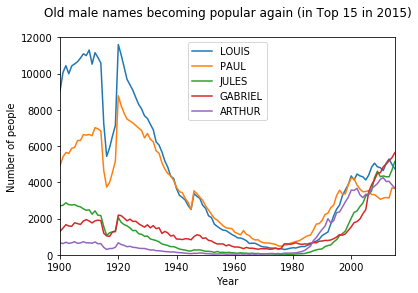

In [27]:
for name in ('LOUIS', 'PAUL', 'JULES', 'GABRIEL', 'ARTHUR'):
    plotname(name, 0)

plt.xlim([1900,2015])
plt.ylim([0,12000])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Old male names becoming popular again (in Top 15 in 2015)\n')
plt.show()

##### In terms of percentage of total male births per year:

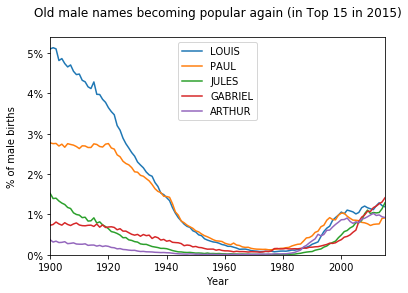

In [28]:
fig, ax = plt.subplots()

for name in ('LOUIS', 'PAUL', 'JULES', 'GABRIEL', 'ARTHUR'):
    plotname_pct(name, 0)

plt.xlim([1900,2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('% of male births')
plt.title('Old male names becoming popular again (in Top 15 in 2015)\n')
plt.show()

#### 'New' male names in Top 15 in 2015
##### In terms of absolute number of births:

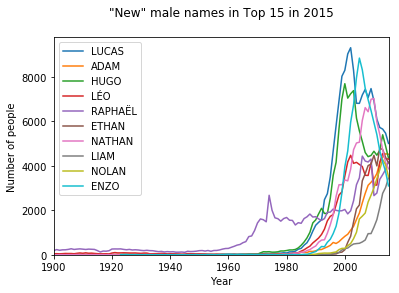

In [29]:
for name in ('LUCAS', 'ADAM', 'HUGO', 'LÉO', 'RAPHAËL', 'ETHAN', 'NATHAN', 'LIAM', 'NOLAN', 'ENZO'):
    plotname(name, 0)

plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('"New" male names in Top 15 in 2015\n')
plt.show()

##### In terms of percentage of total male births per year:

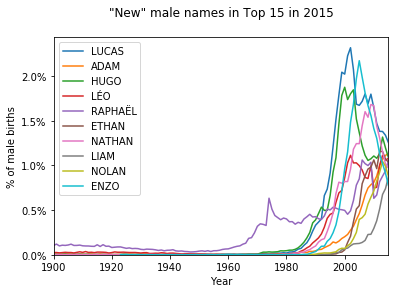

In [30]:
fig, ax = plt.subplots()
for name in ('LUCAS', 'ADAM', 'HUGO', 'LÉO', 'RAPHAËL', 'ETHAN', 'NATHAN', 'LIAM', 'NOLAN', 'ENZO'):
    plotname_pct(name, 0)

plt.xlim([1900,2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('% of male births')
plt.title('"New" male names in Top 15 in 2015\n')
plt.show()

#### Female names in 2015

In [31]:
# Sort the 2015 female names dataframe and show the 15 most common female names in 2015
df2015F = df2015F.sort_values(by='number', ascending=False)
print('Top 15 female names in 2015\n')
print(df2015F.head(15).to_string(columns = ['name', 'number', 'ratio_F'], index=False, col_space = 10))
print('There were ' + str(df2015F.name.nunique()) + ' different female names given in 2015 in France.')

Top 15 female names in 2015

name     number    ratio_F
   LOUISE       4540   1.195426
     EMMA       4399   1.158299
     JADE       4292   1.130125
    CHLOÉ       3598   0.947388
    MANON       3530   0.929483
    ALICE       3336   0.878401
     LINA       3191   0.840221
      LÉA       3100   0.816260
     LOLA       3061   0.805991
  CAMILLE       3020   0.795195
     INÈS       2673   0.703827
    SARAH       2533   0.666963
     ANNA       2504   0.659327
      ZOÉ       2461   0.648005
    LUCIE       2454   0.646162
There were 6782 different female names given in 2015 in France.


#### 'Old' female names becoming popular again (Top 15 in 2015)
##### In terms of absolute number of births:

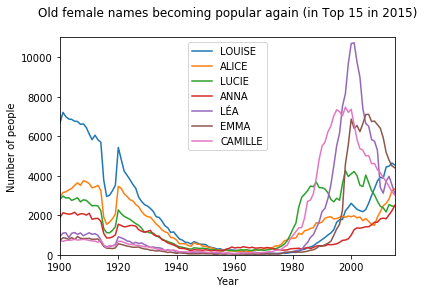

In [32]:
for name in ('LOUISE', 'ALICE', 'LUCIE', 'ANNA', 'LÉA', 'EMMA', 'CAMILLE'):
    plotname(name, 1)

plt.xlim([1900,2015])
plt.ylim([0,11000])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Old female names becoming popular again (in Top 15 in 2015)\n')
plt.show()

##### In terms of percentage of total female births per year:

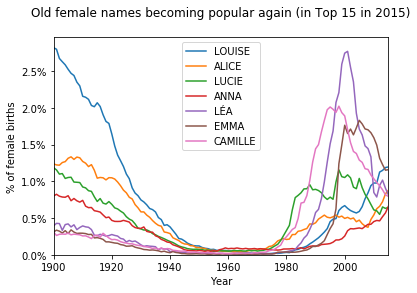

In [33]:
fig, ax = plt.subplots()
for name in ('LOUISE', 'ALICE', 'LUCIE', 'ANNA', 'LÉA', 'EMMA', 'CAMILLE'):
    plotname_pct(name, 1)

plt.xlim([1900,2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('% of female births')
plt.title('Old female names becoming popular again (in Top 15 in 2015)\n')
plt.show()

#### 'New' female names in Top 15 in 2015
##### In terms of absolute number of births:

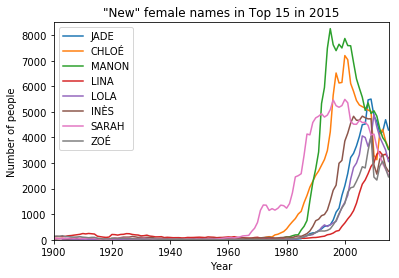

In [34]:
for name in ('JADE', 'CHLOÉ', 'MANON', 'LINA', 'LOLA', 'INÈS', 'SARAH', 'ZOÉ'):
    plotname(name, 1)

plt.xlim([1900,2015])
plt.ylim([0,8500])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('"New" female names in Top 15 in 2015')
plt.show()

##### In terms of percentage of total female births per year:

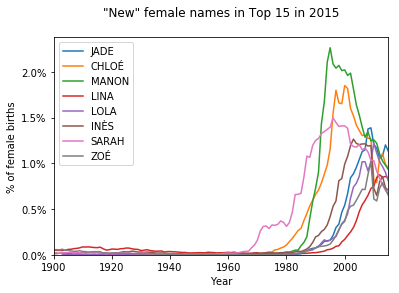

In [35]:
fig, ax = plt.subplots()
for name in ('JADE', 'CHLOÉ', 'MANON', 'LINA', 'LOLA', 'INÈS', 'SARAH', 'ZOÉ'):
    plotname_pct(name, 1)

plt.xlim([1900,2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('% of female births')
plt.title('"New" female names in Top 15 in 2015\n')
plt.show()

#### Very recent new names most likely based on books / movies

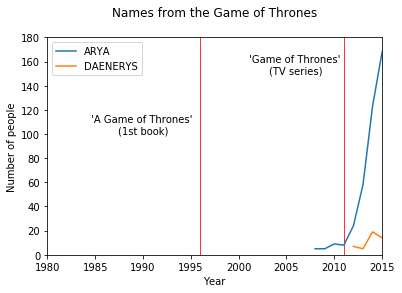

In [36]:
# A Game of Thrones 
plotname('ARYA', 1)
plotname('DAENERYS', 1)
plt.xlim([1980, 2015])
plt.ylim([0,180])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.axvspan(1996, 1996, alpha=0.8, color='red')
plt.annotate("'A Game of Thrones' \n(1st book)", xy=(1990, 100), ha = "center")
plt.axvspan(2011, 2011, alpha=0.8, color='red')
plt.annotate("'Game of Thrones' \n(TV series)", xy=(2006, 150), ha = "center")
plt.title('Names from the Game of Thrones\n')
plt.show()

'A Game of Thrones', the first novel in 'A Song of Ice and Fire' series, was first published in 1996.

However, the story became most popular with the 'Game of Thrones' TV series, which premiered in 2011.

Even though there were a couple of Aryas prior to 2011, the uptake in 'Arya' and 'Daenerys' in France seems to correlate with the 'Game of Thrones' TV series.

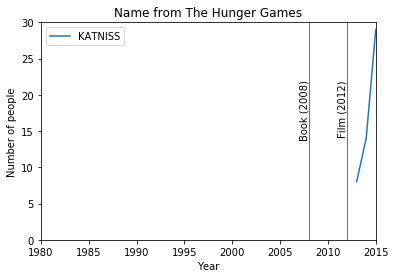

In [37]:
# Hunger Games 
plotname('KATNISS', 1)
plt.xlim([1980, 2015])
plt.ylim([0,30])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.axvspan(2008, 2008, alpha=0.8, color='red')
plt.annotate('Book (2008)', xy=(2007, 21), rotation = 90)
plt.axvspan(2012, 2012, alpha=0.8, color='red')
plt.annotate('Film (2012)', xy=(2011, 21), rotation = 90)
plt.title('Name from The Hunger Games')
plt.show()

The Hunger Games trilogy was published in 2008, 2009 and 2010.

The Hunger Games TV series premiered in 2012.

The name 'Katniss' first appeared in France in 2013, which seems to correlate with the Hunger Games TV series.

However, the effect of both 'A Game of Thrones' and 'The Hunger Games' does not seem that important (maximum 168 female Aryas in 2015). 

In general, the impact of movies, actors, songs, etc. might be overestimated. Cf. Philippe Besnard's research.

A more thorough analysis, for example using IMDb database for movies / characters / actors, could be interesting.

### Most common given names overall between 1900 and 2015

In [38]:
# Calculate number of people per name
total_name = {}
for i in range(len(df.index)):
    if df.iloc[i]['name'] in total_name:
        total_name[df.iloc[i]['name']] += df.iloc[i]['number']
    else:
        total_name[df.iloc[i]['name']] = df.iloc[i]['number']
        
# Create a dataframe from the dictionnary
total = pd.DataFrame.from_dict(total_name, orient='index')
total = total.rename(columns = {0:'number'})

# Sort rows by increasing years
total = total.sort_values(by='number', ascending = 0)

print(total.head(10))

           number
MARIE     2261897
JEAN      1920336
PIERRE     890202
MICHEL     820221
ANDRÉ      712386
JEANNE     550423
PHILIPPE   538393
RENÉ       516882
ALAIN      506763
LOUIS      504555


There is a bias toward "old" names because there were more people with a given name in the past (less diversity in names).

See Section 3: Evolution of the number of names.

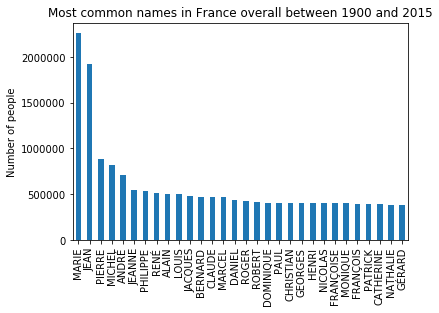

In [39]:
total.head(30).plot(kind='bar', title = 'Most common names in France overall between 1900 and 2015', legend = None)
plt.ylabel("Number of people")
plt.show()

#### Let's look at the 3 most common names: Marie, Jean et Pierre

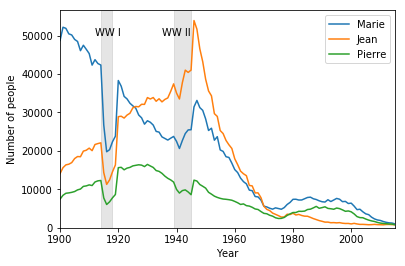

In [40]:
dfMARIE = df[((df.name) == 'MARIE') & ((df.sex) == 1)]
dfJEAN = df[((df.name) == 'JEAN') & ((df.sex) == 0)]
dfPIERRE = df[((df.name) == 'PIERRE') & ((df.sex) == 0)]

plt.plot(dfMARIE.year, dfMARIE.number, label = 'Marie')
plt.plot(dfJEAN.year, dfJEAN.number, label = 'Jean')
plt.plot(dfPIERRE.year, dfPIERRE.number, label = 'Pierre')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 50000))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1935, 50000))
plt.show()

We can see a huge dip during WWI and a peak during the baby boom after WWII.

##### Trend of Marie et Jean (number of people)

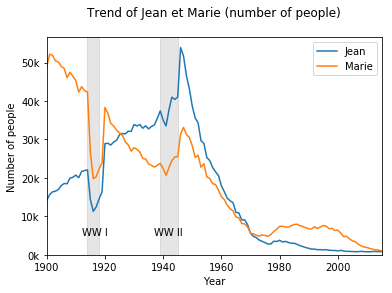

In [41]:
fig, ax = plt.subplots()
dfMARIE = df[((df.name) == 'MARIE') & ((df.sex) == 1)]
dfJEAN = df[((df.name) == 'JEAN') & ((df.sex) == 0)]

plt.plot(dfJEAN.year, dfJEAN.number, label = 'Jean')
plt.plot(dfMARIE.year, dfMARIE.number, label = 'Marie')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,}k'.format(int(x/1000)) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 5000))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1937, 5000))
plt.title('Trend of Jean et Marie (number of people)\n')
plt.savefig('Jean_Marie_Pop.PNG')
plt.show()

##### Trend of Marie et Jean (percentage of total births)

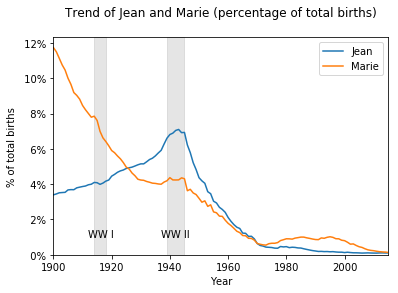

In [42]:
fig, ax = plt.subplots()
plt.plot(dfJEAN.year, dfJEAN.ratio, label = 'Jean')
plt.plot(dfMARIE.year, dfMARIE.ratio, label = 'Marie')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of total births')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 1))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1937,  1))
plt.title('Trend of Jean and Marie (percentage of total births)\n')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.show()

##### Trend of Marie et Jean (percentage of female and male births respectively)

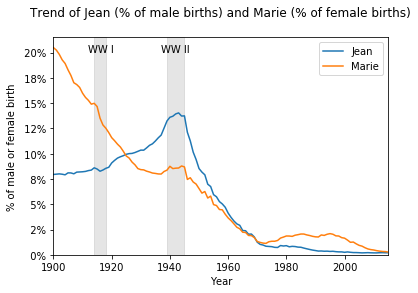

In [43]:
fig, ax = plt.subplots()
plt.plot(dfJEAN.year, dfJEAN.ratio_M, label = 'Jean')
plt.plot(dfMARIE.year, dfMARIE.ratio_F, label = 'Marie')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female birth')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1912, 20))
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1937,  20))
plt.title('Trend of Jean (% of male births) and Marie (% of female births)\n')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.show()

#### Let's look at some of the shortest and longest names

In [44]:
# Longest name (only gives one of the two longest name)
total['name'] = total.index
max_length = 0
for name in set(total.name):
    if len(name) > max_length:
        max_length = len(name)
        longest_name = name
        
print('The longest name given in France between 1900 and 2015 is '+ longest_name 
      + ' which has ' + str(max_length) + ' characters.')

The longest name given in France between 1900 and 2015 is FRANÇOIS-CHRISTOPHE which has 19 characters.


In [45]:
# Alternatively, we can add a column giving the length of each name
for name in set(total.name):
    total.loc[name,'length'] = len(name) 

total = total.sort_values(by = 'length', ascending = 0)

In [46]:
# Let's look at the 10 longest names
print(total[['number', 'length']].head(10))

                     number  length
GUILLAUME-ALEXANDRE      57    19.0
FRANÇOIS-CHRISTOPHE       6    19.0
PHILIPPE-ALEXANDRE       69    18.0
FRANÇOIS-GUILLAUME       97    18.0
FRANÇOIS-DOMINIQUE        6    18.0
FRANÇOIS-ALEXANDRE       58    18.0
PIERRE-CHRISTOPHE        58    17.0
PHILIPPE-EMMANUEL        26    17.0
CLAUDE-EMMANUELLE         3    17.0
MARIE-ALEXANDRINE        42    17.0


In [47]:
# Let's look at the 10 shortest names
print(total[['number', 'length']].tail(10))

    number  length
AH      16     2.0
BY      13     2.0
DE       5     2.0
VI       9     2.0
TO       3     2.0
YA      22     2.0
A        6     1.0
L        6     1.0
N       52     1.0
M      155     1.0


#### Let's look at the name 'M'

The name 'M' was first given in the early 1960s.

This seems to correlate with the first James Bond movie (Dr. No, 1962), where M is the Head of the Secret Intelligence Service and Bond's superior.

It is hard to see correlations with specific movies since there were so many of them, so regularly.

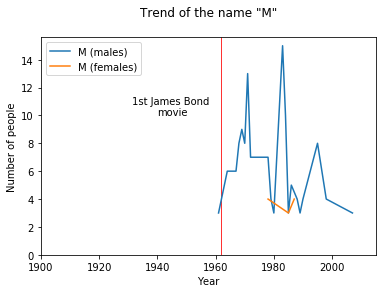

In [48]:
dfM_M = df[((df.name) == 'M') & (df.sex == 0)]
dfM_F = df[((df.name) == 'M') & (df.sex == 1)]
plt.plot(dfM_M.year, dfM_M.number, label = 'M (males)')
plt.plot(dfM_F.year, dfM_F.number, label = 'M (females)')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.legend(loc = 'upper left')
plt.axvspan(1962, 1962, alpha=0.8, color='red')
plt.annotate('1st James Bond \nmovie', xy=(1945, 10), ha = 'center')
plt.title('Trend of the name "M"\n')
plt.show()

## 3. See the trend of some specific names throughout the years

### My first name: Kim!

In [49]:
dfKIM = df[(df.name) == 'KIM']
print('There have been ' + str(sum(dfKIM.number)) + ' people named Kim in France between 1900 and 2015.')

dfKIM_M = df[((df.name) == 'KIM') & ((df.sex) == False)]
print('including ' + str(sum(dfKIM_M.number)) + ' males')

dfKIM_F = df[((df.name) == 'KIM') & ((df.sex) == True)]
print('and ' + str(sum(dfKIM_F.number)) + ' females.')

There have been 5912 people named Kim in France between 1900 and 2015.
including 1153 males
and 4759 females.


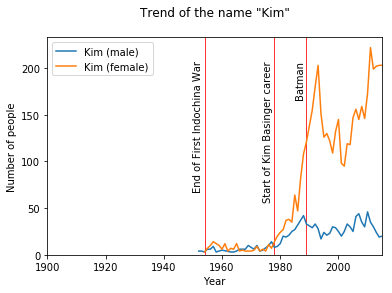

In [50]:
dfKIMF = df[((df.name) == 'KIM') & ((df.sex) == 1)]
dfKIMM = df[((df.name) == 'KIM') & ((df.sex) == 0)]
plt.plot(dfKIMM.year, dfKIMM.number, label = 'Kim (male)')
plt.plot(dfKIMF.year, dfKIMF.number, label = 'Kim (female)')
plt.xlim(1900,2015)
plt.ylim(bottom = 0)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.axvspan(1954, 1954, alpha=0.8, color='red')
plt.annotate('End of First Indochina War', xy=(1950, 200), rotation = 90)
plt.axvspan(1978, 1978, alpha=0.8, color='red')
plt.annotate('Start of Kim Basinger career', xy=(1974, 200), rotation = 90)
plt.axvspan(1989, 1989, alpha=0.8, color='red')
plt.annotate("Batman", xy=(1985, 200), rotation = 90)
plt.title('Trend of the name "Kim"\n')
plt.show()

We can notice the following:
- There were almost no KIM at all in France before 1952 (males) and 1954 (females).
- The number of KIM increases around 1978, and reaches a local maximum (231 Kim’s) in 1993.
- The number of KIM increases again in 2001 from 118 to an absolute maximum of 257 in 2011.


There are probably correlations with:
- Immigration from Vietnam following the First Indochina War (1946-1954). Kim is a Sino-Vietnamese name (金) meaning gold (metal).
- The American actress, Kim Novak, began her career in 1954.
- The American actress, Kim Basinger, starting her acting career around 1978, and gained mainstream exposure in 1989 (Batman).

#### In 1986, the year I was born:

In [51]:
dfKIM_F86 = dfKIM_F[(dfKIM_F.year) == 1986]
print('There were ' + str(sum(dfKIM_F86.number)) + ' females named Kim in France in 1986')

dfKIM_M86 = dfKIM_M[(dfKIM_M.year) == 1986]
print('There were ' + str(sum(dfKIM_M86.number)) + ' males named Kim in France in 1986')

There were 47 females named Kim in France in 1986
There were 32 males named Kim in France in 1986


In [52]:
df1986 = df[(df.year) == 1986]

print(str(sum(df1986.number)) + ' people were born in 1986 in France.')

print('Only ' + str(round((sum(dfKIM_F86.number) + sum(dfKIM_M86.number)) / sum(df1986.number)*100, 2)) + 
      '% of them were named Kim!')

779050 people were born in 1986 in France.
Only 0.01% of them were named Kim!


### Creating a function to get statistics and graphs on a given first name and birth year

In [53]:
def name_stats(name, year):
    name = name.upper()
    
    # General statistics on the name between 1900 and 2015
    print('Number of ' + str(name).title() + ' in France between 1900 and 2015:')
    dfNAME = df[(df.name) == name]
    print('Total: ' + str(sum(dfNAME.number)))
    dfNAME_M = df[((df.name) == name) & ((df.sex) == 0)]
    print('Male ' + str(sum(dfNAME_M.number)))
    dfNAME_F = df[((df.name) == name) & ((df.sex) == 1)]
    print('Female ' + str(sum(dfNAME_F.number)))
    
    # Statistics on the name in given year
    print('\nNumber of ' + str(name).title() + ' in France in ' + str(year) + ':')
    dfNAME_yr = df[((df.name) == name) & ((df.year) == year)]
    print('Total: ' + str(sum(dfNAME_yr.number)))
    dfNAME_Myr = df[((df.name) == name) & ((df.sex) == 0) & ((df.year) == year)]
    print('Males: ' + str(sum(dfNAME_Myr.number)))
    dfNAME_Fyr = df[((df.name) == name) & ((df.sex) == 1) & ((df.year) == year)]
    print('Females: ' + str(sum(dfNAME_Fyr.number)))
        
    # Graph 1 (number of people)
    plt.plot(dfNAME_M.year, dfNAME_M.number, label = str(name) + ' (male)')
    plt.plot(dfNAME_F.year, dfNAME_F.number, label = str(name) + ' (female)')
    plt.xlim([1900,2015])
    plt.ylim(bottom = 0)
    plt.legend(bbox_to_anchor=(1.45, 1), loc='upper right', ncol=1)
    plt.xlabel('Year')
    plt.ylabel('Number of people')
    plt.title('Number of people born with the name ' + str(name))
    plt.show()
    
    # Graph 2 (% of population)
    plt.plot(dfNAME_M.year, dfNAME_M.ratio, label = str(name) + ' (male)')
    plt.plot(dfNAME_F.year, dfNAME_F.ratio, label = str(name) + ' (female)')
    plt.xlim([1900,2015])
    plt.ylim(bottom = 0)
    plt.legend(bbox_to_anchor=(1.45, 1), loc='upper right', ncol=1)
    plt.xlabel('Year')
    plt.ylabel('# ' + str(name) + ' / # births')
    plt.title('Percentage of people born with the name ' + str(name))
    plt.show()
    
    # Most common names in given year
    df_yrM = df[((df.year) == year) & ((df.sex) == 0)]
    df_yrF = df[((df.year) == year) & ((df.sex) == 1)]
    df_yrM = df_yrM.sort_values(by='number', ascending=False)
    df_yrF = df_yrF.sort_values(by='number', ascending=False)
    print('Top 5 male names in ' + str(year))
    print(df_yrM[['name', 'number']].head(5))
    print('\nTop 5 female names in ' + str(year))
    print(df_yrF[['name', 'number']].head(5))
    
    # Rank
    df_yrM['rank'] = df_yrM['number'].rank(ascending=0)
    male_rank = df_yrM.loc[df_yrM['name'] == name]['rank'].values
    if male_rank.size != 0:
        print('\nIn ' + str(year) + ', '+ str(name) + ' was the ' + str(int(male_rank[0])) + 'th most popular male name.')
  
    df_yrF['rank'] = df_yrF['number'].rank(ascending=0)
    female_rank = df_yrF.loc[df_yrF['name'] == name]['rank'].values
    if female_rank.size != 0:
        print('\nIn ' + str(year) + ', '+ str(name) + ' was the ' + str(int(female_rank[0])) + 'th most popular female name.')  

#### Testing the function

Number of Elisabeth in France between 1900 and 2015:
Total: 161158
Male 111
Female 161047

Number of Elisabeth in France in 1960:
Total: 4117
Males: 4
Females: 4113


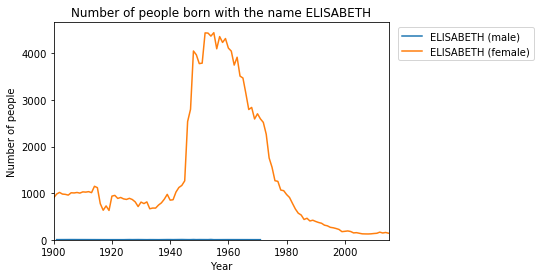

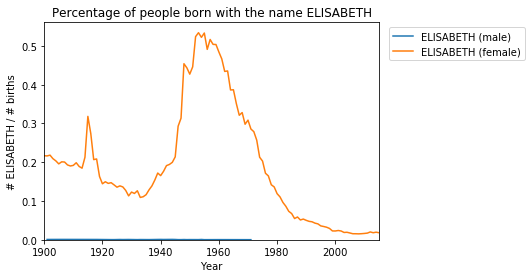

Top 5 male names in 1960
            name  number
201363  PHILIPPE   24761
198704   PATRICK   18522
119080      JEAN   17948
198210    PASCAL   17782
10564      ALAIN   15274

Top 5 female names in 1960
             name  number
317507  CATHERINE   18049
563797     SYLVIE   17656
324800  CHRISTINE   15152
462509      MARIE   15138
311555   BRIGITTE   14615

In 1960, ELISABETH was the 1201th most popular male name.

In 1960, ELISABETH was the 24th most popular female name.


In [54]:
name_stats('elisabeth', 1960)

Number of Anna in France between 1900 and 2015:
Total: 104524
Male 0
Female 104524

Number of Anna in France in 2001:
Total: 1271
Males: 0
Females: 1271


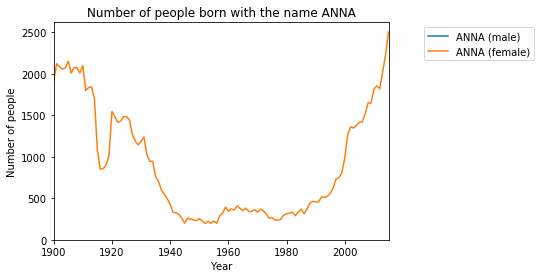

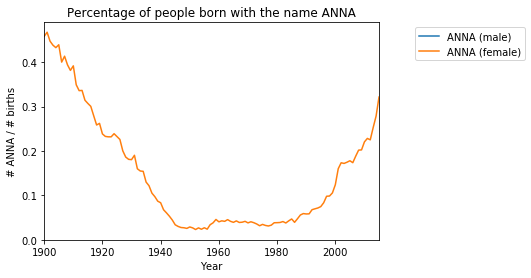

Top 5 male names in 2001
          name  number
243263  THOMAS   10104
156518   LUCAS    9038
243658    THÉO    8864
107508    HUGO    7050
172186  MAXIME    6596

Top 5 female names in 2001
           name  number
448536      LÉA   10725
458358    MANON    7593
323620    CHLOÉ    7040
313874  CAMILLE    6588
354174     EMMA    6394

In 2001, ANNA was the 59th most popular female name.


In [55]:
name_stats('Anna', 2001)

Number of David in France between 1900 and 2015:
Total: 310359
Male 310289
Female 70

Number of David in France in 1986:
Total: 5426
Males: 5426
Females: 0


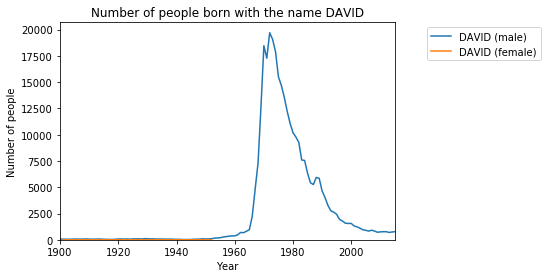

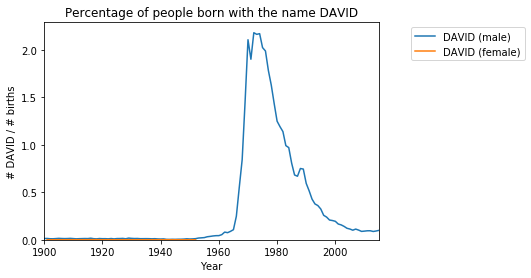

Top 5 male names in 1986
             name  number
136562     JULIEN   15332
189369    NICOLAS   12504
96138   GUILLAUME    9087
12919   ALEXANDRE    8743
238197  SÉBASTIEN    8157

Top 5 female names in 1986
             name  number
302540    AURÉLIE   11320
353631     EMILIE    9320
411595      JULIE    8970
350499     ELODIE    8527
560205  STÉPHANIE    8429

In 1986, DAVID was the 14th most popular male name.


In [56]:
name_stats('DAVID', 1986)

## 4. Evolution of the number of names

### Number of different names per year

The number of unique names per year has increased from less than 1,600 in 1900, to 6000+ in 1986 and 12,000+ in 2015.

Total number of different names between 1900 and 2015: 29459
Number of unique names in 1900: 1593
Number of unique names in 1986: 6390
Number of unique names in 2015: 12354


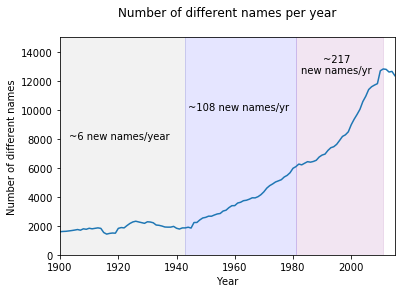

In [57]:
print('Total number of different names between 1900 and 2015: ' + str(df.name.nunique()))

annual_names = df.groupby(['year'])['name'].nunique()

for year in sorted({1900, 1986, 2015}):
    print('Number of unique names in ' + str(year) + ': ' + str(annual_names[year]))

annual_names.plot(kind='line', title = 'Number of different names per year\n')
plt.xlim([1900,2015])
plt.ylim([0,15000])
plt.xlabel('Year')
plt.ylabel('Number of different names')
plt.axvspan(1900, 1943, alpha=0.1, color='grey')
plt.annotate('~6 new names/year', xy=(1903, 8000))
plt.axvspan(1943, 1981, alpha=0.1, color='blue')
plt.annotate('~108 new names/yr', xy=(1944, 10000))
plt.axvspan(1981, 2011, alpha=0.1, color='purple')
plt.annotate('~217\nnew names/yr', xy=(1995, 12500), ha = 'center')
plt.show()

### Ratio of different names per number of births

There is a sharp increase in the number of unique names compared to the increase in the number of births, starting around 1950.

There are so fewer births during the first World War that the ratio of names to births increases.

Ratio of unique names to births in 1900: 0.004
Ratio of unique names to births in 1986: 0.008
Ratio of unique names to births in 2015: 0.016


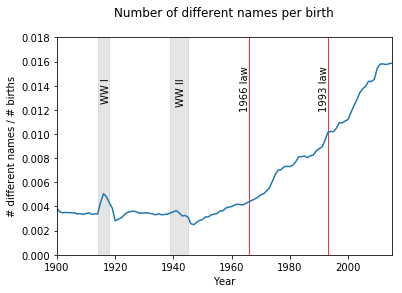

In [58]:
ratio = annual_names / annual_births_series

for year in sorted({1900, 1986, 2015}):
    print('Ratio of unique names to births in ' + str(year) + ': ' + str(round(ratio[year],3)))

ratio.plot(kind='line', title = 'Number of different names per birth\n')
plt.xlim([1900,2015])
plt.ylim([0,0.018])
plt.xlabel('Year')
plt.ylabel('# different names / # births')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1915, 0.014), rotation=90)
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1941,  0.014), rotation=90)
plt.axvspan(1966, 1966, alpha=0.8, color='red')
plt.annotate('1966 law', xy=(1963,  0.015), rotation=90)
plt.axvspan(1993, 1993, alpha=0.8, color='red')
plt.annotate('1993 law', xy=(1990,  0.015), rotation=90)
plt.show()

The 'Law of 1803', created by Napoléon Bonaparte, limited names to those found in calendars and 'historic names'. 

See 'Loi relative aux prénoms et changements de Noms du 11 Germinal' (N° 2614) http://legilux.public.lu/eli/etat/leg/loi/1803/04/01/n1/jo

Given the emergence of new names, the 'Law of 1966' extended the repertoire of authorized names to some mythology names, regional names, foreign names, etc.

Finally, the 'Law of 1993' repealed the 'Law of 1803' and authorized virtually any name, as long as it is not contrary to the interests of the child (e.g., offensive or embarrassing names).

### Percentage of births represented by the Top 20 names

In [59]:
def topx(year, x):
    dfyear = subdf(year = year)
    dfyear = dfyear.sort_values(by='number', ascending=False)
    percent20 = dfyear.ratio.head(x).sum()
    print('Top 20 names in {}\n'.format(year))
    print(dfyear.head(x).to_string(columns = ['sex', 'name', 'number', 'ratio'], index = False, col_space = 10))
    print('\nIn {}, the Top 20 names represented {}% of total births that year.'.format(year, round(percent20,1)))

In [60]:
topx(1900,20)

Top 20 names in 1900

sex        name     number      ratio
     True       MARIE      48727  11.735677
    False        JEAN      14108   3.397848
     True      JEANNE      13983   3.367742
    False       LOUIS       9057   2.181337
     True  MARGUERITE       8059   1.940974
    False      PIERRE       7460   1.796707
    False      JOSEPH       7263   1.749261
     True    GERMAINE       6981   1.681342
    False       HENRI       6924   1.667614
     True      LOUISE       6698   1.613183
    False      MARCEL       6542   1.575611
    False     GEORGES       5664   1.364149
    False       ANDRÉ       5532   1.332357
     True      YVONNE       5099   1.228071
     True   MADELEINE       4960   1.194594
     True     SUZANNE       4954   1.193148
    False        PAUL       4925   1.186164
    False        RENÉ       4773   1.149555
    False     CHARLES       4367   1.051772
    False    FRANÇOIS       4310   1.038044

In 1900, the Top 20 names represented 43.4% of total births

In [61]:
topx(2015,20)

Top 20 names in 2015

sex       name     number      ratio
    False    GABRIEL       5640   0.724292
    False      JULES       5147   0.660981
    False      LUCAS       5011   0.643516
    False      LOUIS       4748   0.609741
     True     LOUISE       4540   0.583030
    False       ADAM       4526   0.581232
     True       EMMA       4399   0.564922
    False       HUGO       4349   0.558501
    False        LÉO       4303   0.552594
     True       JADE       4292   0.551181
    False    RAPHAËL       4196   0.538853
    False      ETHAN       4135   0.531019
    False     NATHAN       3871   0.497116
    False     ARTHUR       3688   0.473615
    False       PAUL       3654   0.469249
     True      CHLOÉ       3598   0.462057
     True      MANON       3530   0.453325
    False      NOLAN       3513   0.451142
    False       LIAM       3466   0.445106
     True      ALICE       3336   0.428411

In 2015, the Top 20 names represented 10.8% of total births that year.


### Rare names

We can also notice how the number of people with rare names increased from 2,980 in 1900 (0.7% of births) to 56,107 in 2015 (7.2% of births).

Rare names are names with less than 20 people between 1900 and 1945 (condition 1), and less than 20 people between 1946 and 2015 (condition 2).

Rare names in 1900: 2980 people (0.7% of births)
Rare names in 2015: 56107 people (7.2% of births)


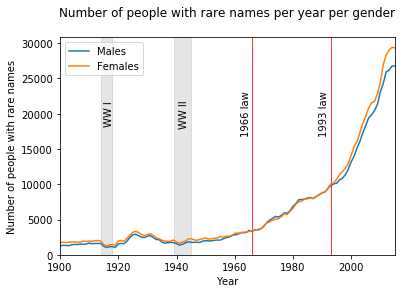

In [62]:
df_rare_M = df_rare[((df_rare.sex) == 0)]
df_rare_F = df_rare[((df_rare.sex) == 1)]

for year in sorted({1900, 2015}):
    nb = sum(df_rare[((df_rare.year) == year)].number)
    percentage = 100 * nb / (sum(df[((df.year) == year)].number) + sum(df_rare[((df_rare.year) == year)].number))
    print('Rare names in ' + str(year) + ': ' + 
          str(nb) + ' people ' +
          '(' + str(round(percentage, 1)) + '% of births' + ')')

plt.plot(df_rare_M.year, df_rare_M.number, label = 'Males')
plt.plot(df_rare_F.year, df_rare_F.number, label = 'Females')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people with rare names')
plt.title('Number of people with rare names per year per gender\n')
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1915, 20000), rotation=90, va = 'center')
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1941,  20000), rotation=90, va = 'center')
plt.axvspan(1966, 1966, alpha=0.8, color='red')
plt.annotate('1966 law', xy=(1962,  20000), rotation=90, va = 'center')
plt.axvspan(1993, 1993, alpha=0.8, color='red')
plt.annotate('1993 law', xy=(1989,  20000), rotation=90, va = 'center')
plt.show()

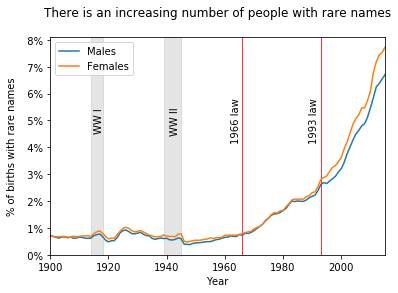

In [63]:
fig, ax = plt.subplots()
plt.plot(df_rare_M.year, df_rare_M.ratio_M, label = 'Males')
plt.plot(df_rare_F.year, df_rare_F.ratio_F, label = 'Females')
plt.xlim([1900,2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('% of births with rare names')
plt.title('There is an increasing number of people with rare names\n')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.axvspan(1914, 1918, alpha=0.2, color='grey')
plt.annotate('WW I', xy=(1915, 5), rotation=90, va = 'center')
plt.axvspan(1939, 1945, alpha=0.2, color='grey')
plt.annotate('WW II', xy=(1941,  5), rotation=90, va = 'center')
plt.axvspan(1966, 1966, alpha=0.8, color='red')
plt.annotate('1966 law', xy=(1962,  5), rotation=90, va = 'center')
plt.axvspan(1993, 1993, alpha=0.8, color='red')
plt.annotate('1993 law', xy=(1989,  5), rotation=90, va = 'center')
plt.show()

## 5. Name trends

Cf. Philippe Besnard's research.

### Identifying the most common trigrams
#### Create a function to identify the most common trigrams overall

In [64]:
n = 3
trigram_dict = {}

for i in range(len(df.index)):
    name = df.iloc[i]['name']
    number = df.iloc[i]['number']
    for trigram in ngrams(name, n):
        if trigram in trigram_dict:
            trigram_dict[trigram] += number
        else:
            trigram_dict[trigram] = number
            
# Create a dataframe from the dictionnary
df_trigram = pd.DataFrame.from_dict(trigram_dict, orient='index')
df_trigram['trigram'] = df_trigram.index
df_trigram = df_trigram.rename(columns = {0:'occurences'})

# Sort rows by increasing occurences
df_trigram = df_trigram.sort_values(by='occurences', ascending = False)

# Reorder columns
df_trigram = df_trigram[['trigram', 'occurences']] 

C:\Conda\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: generator 'ngrams' raised StopIteration


In [65]:
print(df_trigram.head(25).to_string(index = False, col_space = 15))

trigram      occurences
     (I, N, E)         6558990
     (M, A, R)         6371275
     (R, I, E)         4429764
     (A, R, I)         4359901
     (E, A, N)         4190095
     (J, E, A)         4165535
     (A, N, N)         2900497
     (T, T, E)         2750917
     (N, N, E)         2707167
     (A, N, D)         2675611
     (L, L, E)         2498431
     (R, I, C)         2436297
     (E, T, T)         2418247
     (I, E, R)         2260614
     (Q, U, E)         2250395
     (L, A, U)         2128209
     (L, I, E)         2080610
     (I, E, N)         1974329
     (I, S, T)         1905430
     (R, I, S)         1901260
     (E, L, L)         1859142
     (B, E, R)         1851988
     (N, D, R)         1835679
     (L, I, N)         1798648
     (I, A, N)         1789559


We note the following:
- 'INE' is the most common trigram overall (e.g., Catherine, Jacqueline)
- 'MAR', 'RIE', 'ARI' are very common due to the popularity of 'MARIE'
- 'EAN', 'JEA' are very common due to the popularity of 'JEAN'

#### Create a function to identify some of the names including the most common trigrams.

In [66]:
def trigram_name(trigram, minnumber):
    df_trigram = df[df.name.str.contains(trigram)]
    df_trigram_series = df_trigram.groupby(['name'])['number'].sum()
    print('Names containing {} with at least {} births overall between 1900 and 2015'.format(trigram, minnumber))
    print(df_trigram_series[df_trigram_series > minnumber].sort_values(ascending = False))

### Trend of female names ending in '-INE'

In [67]:
trigram_name('INE', 100000)

Names containing INE with at least 100000 births overall between 1900 and 2015
name
CATHERINE     394803
JACQUELINE    372540
MARTINE       320208
MADELEINE     303769
CHRISTINE     280523
ANTOINE       270462
SANDRINE      240281
CÉLINE        238057
JEANNINE      218682
GERMAINE      211176
CLAUDINE      158987
CAROLINE      156019
PAULINE       154426
GINETTE       131670
NADINE        131279
DELPHINE      127517
KARINE        121039
MARINE        118642
MICHELINE     111887
Name: number, dtype: int32


Most names containing '- INE' end with these three letters, and are female names (except for 'Antoine').

#### In general, female names ending in '-INE' were most popular between 1950 and 1980

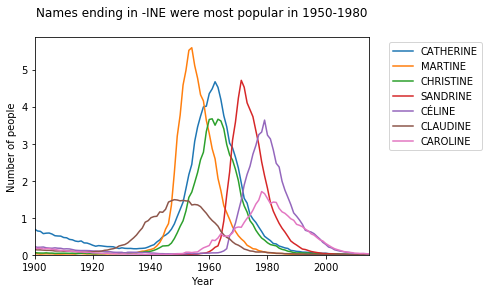

In [68]:
for name in ('CATHERINE',  'MARTINE', 'CHRISTINE', 'SANDRINE', 'CÉLINE', 'CLAUDINE', 'CAROLINE'):
    plotname_pct(name, 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', ncol=1)
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Names ending in -INE were most popular in 1950-1980\n')
plt.show()

### Trends of names containing 'LAU'

In [69]:
trigram_name('LAU', 20000)

Names containing LAU with at least 20000 births overall between 1900 and 2015
name
CLAUDE          468454
LAURENT         328388
GUILLAUME       222148
LAURENCE        181797
JEAN-CLAUDE     172142
CLAUDINE        158987
LAURA           145488
LAURE            82938
MARIE-CLAUDE     57187
CLAUDETTE        47747
MARIE-LAURE      35222
LAURIE           29660
CLAUDIE          24674
LAURINE          24604
ANNE-LAURE       20356
CLAUDIA          20278
Name: number, dtype: int32


#### Names containing 'LAURE' were most popular in 1960-1985

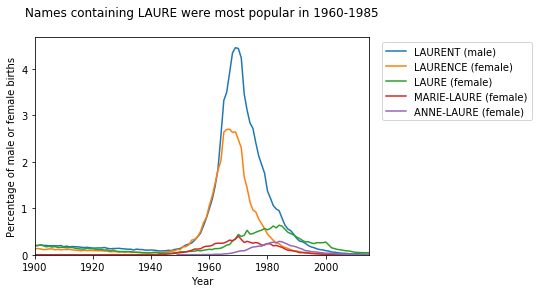

In [70]:
plotname_pct('LAURENT', 0, genderlabel = True)
    
for name in ('LAURENCE',  'LAURE', 'MARIE-LAURE', 'ANNE-LAURE'):
    plotname_pct(name, 1, genderlabel = True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(bbox_to_anchor=(1.50, 1), loc='upper right', ncol=1)
plt.xlabel('Year')
plt.ylabel('Percentage of male or female births')
plt.title('Names containing LAURE were most popular in 1960-1985\n')
plt.show()

#### Names containing 'CLAUD' were most popular in 1930-1960

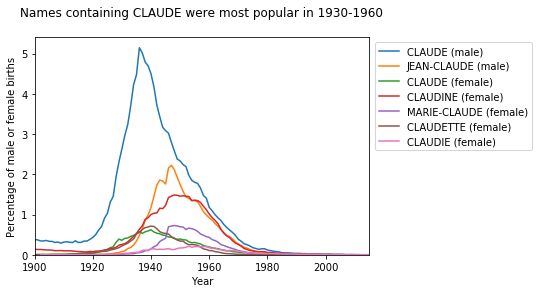

In [71]:
for name in ('CLAUDE',  'JEAN-CLAUDE'):
    plotname_pct(name, 0, genderlabel = True)
    
for name in ('CLAUDE',  'CLAUDINE', 'MARIE-CLAUDE', 'CLAUDETTE', 'CLAUDIE'):
    plotname_pct(name, 1, genderlabel = True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(bbox_to_anchor=(1.50, 1), loc='upper right', ncol=1)
plt.xlabel('Year')
plt.ylabel('Percentage of male or female births')
plt.title('Names containing CLAUDE were most popular in 1930-1960\n')
plt.show()

### Trend of female names ending in '-IANE'

In [72]:
trigram_name('IANE', 10000)

Names containing IANE with at least 10000 births overall between 1900 and 2015
name
CHRISTIANE    259535
JOSIANE       123110
ELIANE        113532
LILIANE       112028
SYLVIANE       53059
VIVIANE        52746
SOFIANE        22437
FLORIANE       19551
DIANE          18808
LAURIANE       13740
DORIANE        10494
LYSIANE        10093
Name: number, dtype: int32


Names containing 'IANE' with at least 10,000 births all end with these letters and are exclusively female, except for 'SOFIANE'.

#### In general, female names ending in '-IANE' were most popular in 1940-1960
##### In terms of absolute number of births:

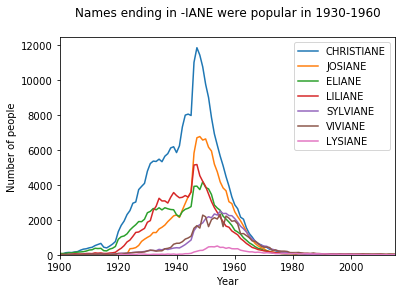

In [73]:
for name in ('CHRISTIANE', 'JOSIANE', 'ELIANE', 'LILIANE', 'SYLVIANE', 'VIVIANE', 'LYSIANE'):
    plotname(name, 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Names ending in -IANE were popular in 1930-1960\n')
plt.show()

##### In terms of percentage of total female births per year:

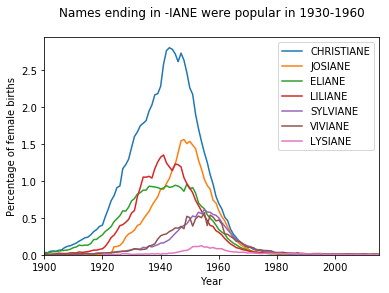

In [74]:
for name in ('CHRISTIANE', 'JOSIANE', 'ELIANE', 'LILIANE', 'SYLVIANE', 'VIVIANE', 'LYSIANE'):
    plotname_pct(name, 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Percentage of female births')
plt.title('Names ending in -IANE were popular in 1930-1960\n')
plt.show()

#### Exceptions to the '-IANE rule'
There are only a couple of exceptions of names ending in '-iane' with at least 10,000 people in total between 1900-2015, that were popular after the 1930-1960.

This phenomenon was on a much smaller scale, up to almost 12,000 people for 'Christiane' in 1947, versus about 1,000 people for 'Floriane' in 1991.

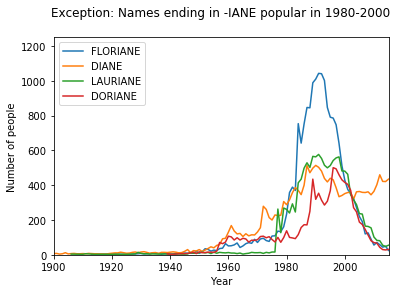

In [75]:
for name in ('FLORIANE', 'DIANE', 'LAURIANE', 'DORIANE'):
    plotname(name, 1)
    
plt.xlim([1900, 2015])
plt.ylim([0,1250])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Exception: Names ending in -IANE popular in 1980-2000\n')
plt.show()

### Trend of female names ending in '-ETTE'

In [76]:
trigram_name('ETTE', 10000)

Names containing ETTE with at least 10000 births overall between 1900 and 2015
name
PAULETTE      213443
YVETTE        203485
ODETTE        192683
COLETTE       174267
JULIETTE      156688
JOSETTE       154200
GEORGETTE     153061
BERNADETTE    141557
GINETTE       131670
HENRIETTE     126999
HUGUETTE       90185
PIERRETTE      81955
ARLETTE        78588
ANTOINETTE     72578
LUCETTE        69931
MAURICETTE     52842
CLAUDETTE      47747
ANNETTE        33488
VIOLETTE       22007
LOUISETTE      20109
JEANNETTE      19629
MARINETTE      17375
SYLVETTE       14852
MARIETTE       10744
Name: number, dtype: int32


#### In general, female names ending in '-ETTE' were most popular in 1920-1940
##### In terms of absolute number of births:

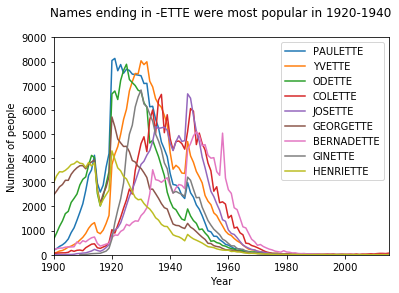

In [77]:
for name in ('PAULETTE', 'YVETTE', 'ODETTE', 'COLETTE', 'JOSETTE', 'GEORGETTE', 'BERNADETTE', 'GINETTE', 'HENRIETTE'):
    plotname(name, 1)

plt.xlim([1900, 2015])
plt.ylim([0,9000])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Names ending in -ETTE were most popular in 1920-1940\n')
plt.show()

##### In terms of percentage of total female births per year:

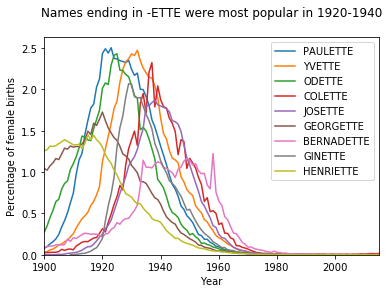

In [78]:
for name in ('PAULETTE', 'YVETTE', 'ODETTE', 'COLETTE', 'JOSETTE', 'GEORGETTE', 'BERNADETTE', 'GINETTE', 'HENRIETTE'):
    plotname_pct(name, 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Percentage of female births')
plt.title('Names ending in -ETTE were most popular in 1920-1940\n')
plt.show()

#### A notable exception to the '-ETTE rule' is 'Juliette'.
##### In terms of absolute number of births:

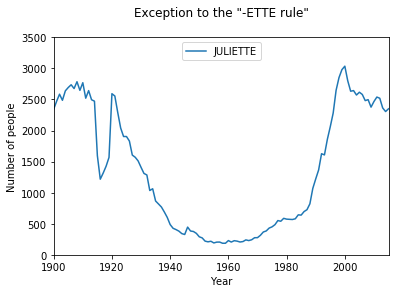

In [79]:
plotname('JULIETTE', 1)

plt.xlim([1900, 2015])
plt.ylim([0,3500])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Exception to the "-ETTE rule"\n')
plt.show()

##### In terms of percentage of total female births per year:

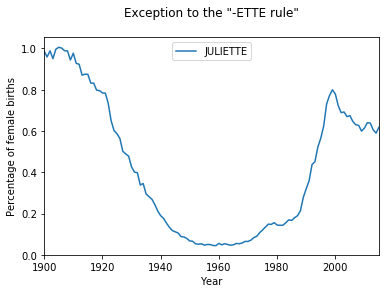

In [80]:
plotname_pct('JULIETTE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('Percentage of female births')
plt.title('Exception to the "-ETTE rule"\n')
plt.show()

### Trend of compound names

#### Female compound names were most popular in 1940-1965

In [81]:
# Identify female compound names with at least 10,000 people in total
df_compoundF = df[(df.name.str.contains('-')) & (df.sex == 1)]
df_compoundF_series = df_compoundF.groupby(['name'])['number'].sum()

print(df_compoundF_series[df_compoundF_series > 10000].sort_values(ascending = False))

name
ANNE-MARIE         99695
MARIE-THÉRÈSE      88345
MARIE-CHRISTINE    74956
MARIE-CLAUDE       57167
MARIE-FRANCE       53601
MARIE-LOUISE       48508
MARIE-HÉLÈNE       37549
MARIE-CLAIRE       35685
MARIE-LAURE        35222
MARIE-JOSÉ         34651
ANNE-SOPHIE        32285
MARIE-PIERRE       31502
MARIE-FRANÇOISE    27809
MARIE-NOËLLE       21156
ANNE-LAURE         20356
MARIE-JEANNE       19486
MARIE-PAULE        18814
MARIE-ANGE         16612
MARIE-LINE         16170
MARIE-ROSE         12411
MARIE-MADELEINE    12276
MARIE-ANNE         11900
ROSE-MARIE         10627
MARIE-JOSEPHE      10318
MARIE-ODILE        10231
Name: number, dtype: int32


Most of the female compound names with at least 10,000 people in total since 1900 comprised the name 'MARIE'! (Marie is the most common female name overall in France between 1900 and 2015.)

##### In terms of absolute number of births:

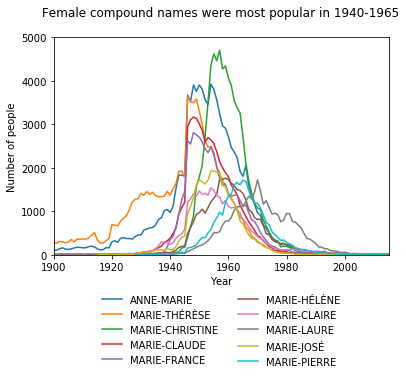

In [82]:
for name in ('ANNE-MARIE',  'MARIE-THÉRÈSE', 'MARIE-CHRISTINE', 'MARIE-CLAUDE', 'MARIE-FRANCE', 'MARIE-HÉLÈNE', 'MARIE-CLAIRE',\
             'MARIE-LAURE', 'MARIE-JOSÉ', 'MARIE-PIERRE'):
    plotname(name, 1)

plt.xlim([1900, 2015])
plt.ylim([0,5000])
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2).get_frame().set_edgecolor('w')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Female compound names were most popular in 1940-1965\n')
plt.show()

##### In terms of percentage of total female births per year:

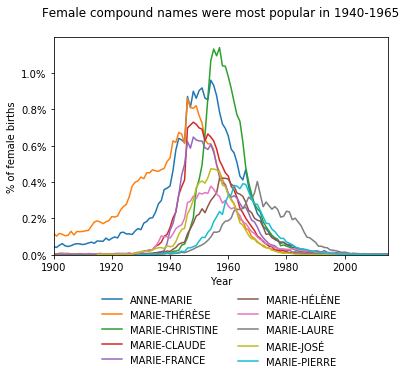

In [83]:
fig, ax = plt.subplots()

for name in ('ANNE-MARIE',  'MARIE-THÉRÈSE', 'MARIE-CHRISTINE', 'MARIE-CLAUDE', 'MARIE-FRANCE', 'MARIE-HÉLÈNE', 'MARIE-CLAIRE',\
             'MARIE-LAURE', 'MARIE-JOSÉ', 'MARIE-PIERRE'):
    plotname_pct(name, 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=2).get_frame().set_edgecolor('w')
plt.xlabel('Year')
plt.ylabel('% of female births')
plt.title('Female compound names were most popular in 1940-1965\n')
plt.show()

#### In general, male compound names were also most popular in 1940-1965

In [84]:
# Identify male compound names with at least 10,000 people in total
df_compoundM = df[(df.name.str.contains('-')) & (df.sex == 0)]
df_compoundM_series = df_compoundM.groupby(['name'])['number'].sum()

print(df_compoundM_series[df_compoundM_series > 10000].sort_values(ascending = False))

name
JEAN-PIERRE        213143
JEAN-CLAUDE        172142
JEAN-LUC           116647
JEAN-FRANÇOIS       99024
JEAN-MARC           90144
JEAN-PAUL           86843
JEAN-MARIE          86223
JEAN-MICHEL         85960
JEAN-LOUIS          79826
JEAN-JACQUES        53423
JEAN-BAPTISTE       48549
JEAN-PHILIPPE       45672
JEAN-YVES           37180
JEAN-CHRISTOPHE     31847
JEAN-CHARLES        19269
JEAN-NOËL           14776
Name: number, dtype: int32


All the male compound names with at least 10,000 people in total since 1900 comprised the name 'JEAN'! (Jean is the most common male name overall in France between 1900 and 2015.)

##### In terms of absolute number of births:

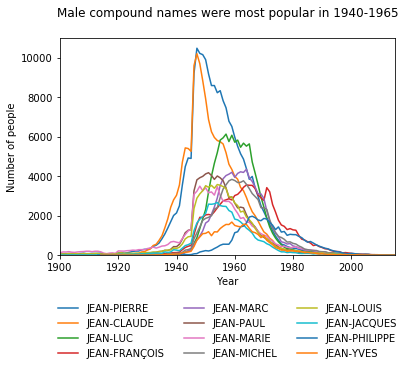

In [85]:
for name in ('JEAN-PIERRE',  'JEAN-CLAUDE', 'JEAN-LUC', 'JEAN-FRANÇOIS', 'JEAN-MARC', 'JEAN-PAUL', 'JEAN-MARIE',\
             'JEAN-MICHEL', 'JEAN-LOUIS', 'JEAN-JACQUES', 'JEAN-PHILIPPE', 'JEAN-YVES'):
    plotname(name, 0)

plt.xlim([1900, 2015])
plt.ylim([0,11000])
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3).get_frame().set_edgecolor('w')
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Male compound names were most popular in 1940-1965\n')
plt.show()

##### In terms of percentage of total male births per year:

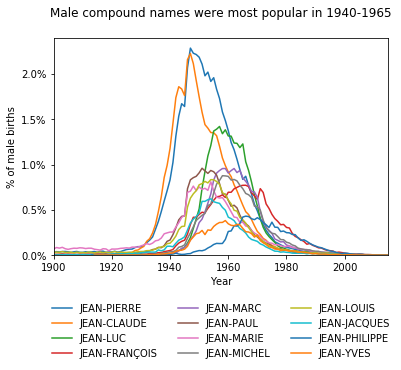

In [86]:
fig, ax = plt.subplots()

for name in ('JEAN-PIERRE',  'JEAN-CLAUDE', 'JEAN-LUC', 'JEAN-FRANÇOIS', 'JEAN-MARC', 'JEAN-PAUL', 'JEAN-MARIE',\
             'JEAN-MICHEL', 'JEAN-LOUIS', 'JEAN-JACQUES', 'JEAN-PHILIPPE', 'JEAN-YVES'):
    plotname_pct(name, 0)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3).get_frame().set_edgecolor('w')
plt.xlabel('Year')
plt.ylabel('% of male births')
plt.title('Male compound names were most popular in 1940-1965\n')
plt.show()

### In general, pairs of male/female names are popular at the same period

#### Finding pairs of male/female names using five-gram

In [87]:
n = 5
fivegram_dict = {}

for i in range(len(df.index)):
    name = df.iloc[i]['name']
    number = df.iloc[i]['number']
    for fivegram in ngrams(name, n):
        if fivegram in fivegram_dict:
            fivegram_dict[fivegram] += number
        else:
            fivegram_dict[fivegram] = number
            
# Create a dataframe from the dictionnary
df_fivegram = pd.DataFrame.from_dict(fivegram_dict, orient='index')
df_fivegram['fivegram'] = df_fivegram.index
df_fivegram = df_fivegram.rename(columns = {0:'occurences'})

# Sort rows by increasing occurences
df_fivegram = df_fivegram.sort_values(by='occurences', ascending = False)

# Reorder columns
df_fivegram = df_fivegram[['fivegram', 'occurences']] 

C:\Conda\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: generator 'ngrams' raised StopIteration


In [88]:
print(df_fivegram.head(25).to_string(index = False, col_space = 15))

fivegram      occurences
(M, A, R, I, E)         3350984
(C, H, R, I, S)         1687806
(H, R, I, S, T)         1682227
(J, E, A, N, -)         1367942
(P, I, E, R, R)         1296353
(I, E, R, R, E)         1272657
(M, I, C, H, E)         1142454
(I, C, H, E, L)         1142417
(N, I, Q, U, E)         1056314
(R, I, S, T, I)         1055096
(A, N, D, R, É)          984694
(C, L, A, U, D)          967764
(L, O, U, I, S)          943183
(F, R, A, N, Ç)          940279
(A, N, Ç, O, I)          940137
(R, A, N, Ç, O)          940137
(N, Ç, O, I, S)          940137
(J, A, C, Q, U)          914287
(A, C, Q, U, E)          910198
(A, T, R, I, C)          877491
(A, R, I, E, -)          838653
(J, E, A, N, N)          821580
(L, A, U, D, E)          749207
(P, A, T, R, I)          746110
(J, U, L, I, E)          745246


#### Laurent / Laurence were both most popular in 1965-1975

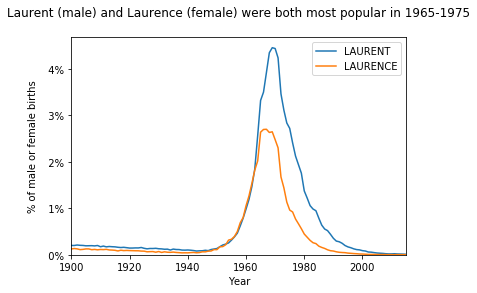

In [89]:
fig, ax = plt.subplots()

plotname_pct('LAURENT', 0)
plotname_pct('LAURENCE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Laurent (male) and Laurence (female) were both most popular in 1965-1975\n')
plt.show()

#### Christian / Christiane were both most popular in 1940-1960

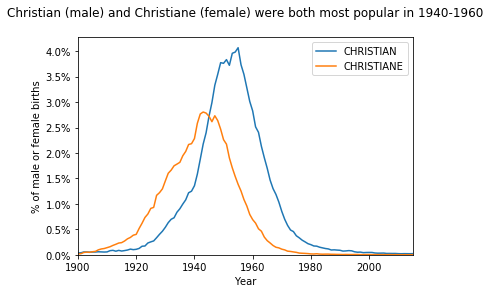

In [90]:
fig, ax = plt.subplots()

plotname_pct('CHRISTIAN', 0)
plotname_pct('CHRISTIANE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Christian (male) and Christiane (female) were both most popular in 1940-1960\n')
plt.show()

#### Louis / Louise were most popular at the same periods, 1900-1930 and since 1995

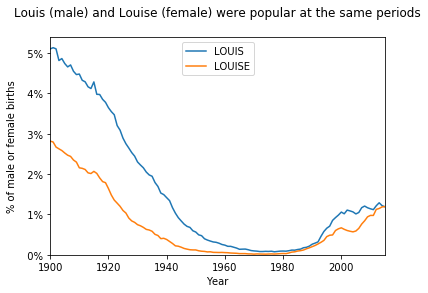

In [91]:
fig, ax = plt.subplots()

plotname_pct('LOUIS', 0)
plotname_pct('LOUISE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.legend(loc='upper center')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Louis (male) and Louise (female) were popular at the same periods\n')
plt.show()

#### Michel / Michelle were both most popular in 1930-1955

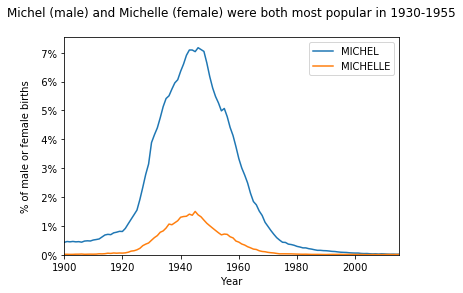

In [92]:
fig, ax = plt.subplots()

plotname_pct('MICHEL', 0)
plotname_pct('MICHELLE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Michel (male) and Michelle (female) were both most popular in 1930-1955\n')
plt.show()

#### Dominique (male) / Dominique (female) were both most popular in 1950-1965

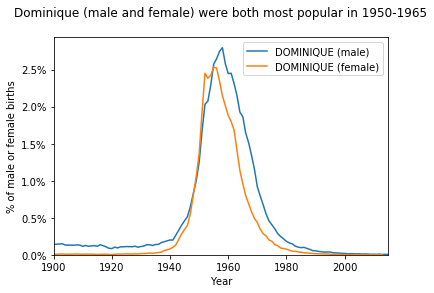

In [93]:
fig, ax = plt.subplots()

plotname_pct('DOMINIQUE', 0, genderlabel=True)
plotname_pct('DOMINIQUE', 1, genderlabel=True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Dominique (male and female) were both most popular in 1950-1965\n')
plt.show()

#### Patrice / Patricia were both most popular in 1950-1975

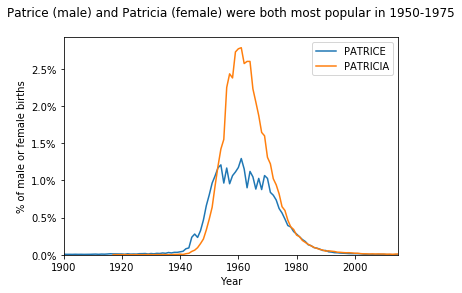

In [94]:
fig, ax = plt.subplots()

plotname_pct('PATRICE', 0)
plotname_pct('PATRICIA', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Patrice (male) and Patricia (female) were both most popular in 1950-1975\n')
plt.show()

#### Julien / Julie were both most popular in 1975-1995

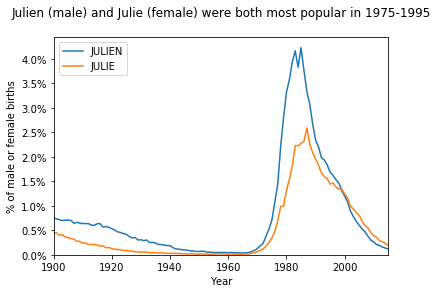

In [95]:
fig, ax = plt.subplots()

plotname_pct('JULIEN', 0)
plotname_pct('JULIE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Julien (male) and Julie (female) were both most popular in 1975-1995\n')
plt.show()

#### André / Andrée were both most popular in 1910-1940

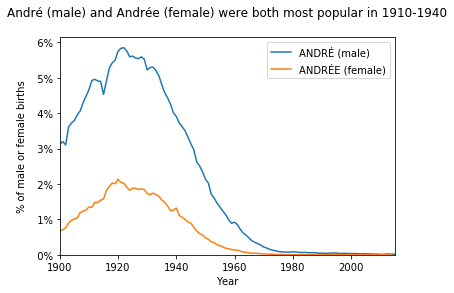

In [96]:
fig, ax = plt.subplots()

plotname_pct('ANDRÉ', 0, genderlabel = True)
plotname_pct('ANDRÉE', 1, genderlabel = True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('André (male) and Andrée (female) were both most popular in 1910-1940\n')
plt.show()

#### Jacques / Jacqueline were both most popular in 1920-1950

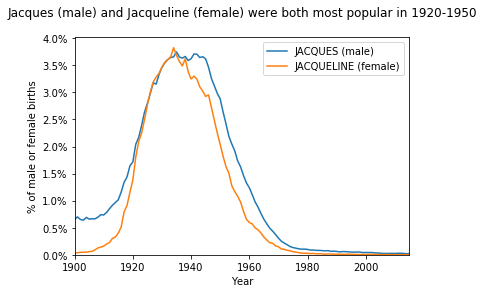

In [97]:
fig, ax = plt.subplots()

plotname_pct('JACQUES', 0, genderlabel = True)
plotname_pct('JACQUELINE', 1, genderlabel = True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Jacques (male) and Jacqueline (female) were both most popular in 1920-1950\n')
plt.show()

#### Joël / Joëlle were both most popular in 1945-1965

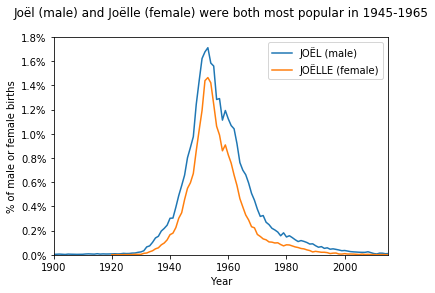

In [98]:
fig, ax = plt.subplots()

plotname_pct('JOËL', 0, genderlabel = True)
plotname_pct('JOËLLE', 1, genderlabel = True)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in vals])
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('% of male or female births')
plt.title('Joël (male) and Joëlle (female) were both most popular in 1945-1965\n')
plt.show()

#### Exceptions to the parallel male/female name trend

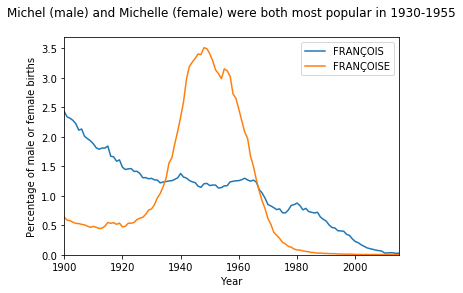

In [99]:
plotname_pct('FRANÇOIS', 0)
plotname_pct('FRANÇOISE', 1)

plt.xlim([1900, 2015])
plt.ylim(bottom = 0)
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Percentage of male or female births')
plt.title('Michel (male) and Michelle (female) were both most popular in 1930-1955\n')
plt.show()

## 6. Evolution of the length of names

Inspired by INSEE analysis: 

'L'évolution des prénoms en région Centre : plus courts et plus variés que par le passé'

('The evolution of first names in the Centre region of France: shorter and more diverse than in the past')

https://www.insee.fr/fr/statistiques/1292923

In [100]:
# Calculate length of names per year weighted by the number of births
names_length = {}
for i in range(len(df.index)):
    if df.iloc[i]['year'] in names_length:
        names_length[df.iloc[i]['year']] += len(str(df.iloc[i]['name'])) * df.iloc[i]['number']
    else:
        names_length[df.iloc[i]['year']] = len(str(df.iloc[i]['name'])) * df.iloc[i]['number']

# Create a dataframe from the dictionnary
length = pd.DataFrame.from_dict(names_length, orient='index')
length['year'] = length.index
length = length.rename(columns = {0:'length'})

# Sort rows by increasing years
length = length.sort_values(by='year')

# Reorder columns
length = length[['year', 'length']] 

# Add a column with number of births per year
length['births'] = df.groupby(['year'])['number'].sum()

# Add a column with mean length of names per year (mean weighted by number of births)
length['avg_length'] = length['length'] / length['births']

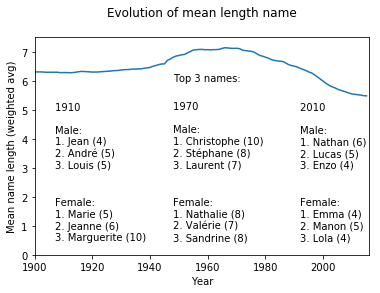

In [101]:
# Create graph
plt.plot(length.year, length.avg_length)
plt.xlabel('Year')
plt.ylabel('Mean name length (weighted avg)')
plt.xlim([1900,2016])
plt.ylim([0,7.5])
plt.annotate('Top 3 names:', (1948,6))
plt.annotate('1910 \n\nMale: \n1. Jean (4)\n2. André (5)\n3. Louis (5)', (1907,3))
plt.annotate('Female: \n1. Marie (5)\n2. Jeanne (6)\n3. Marguerite (10)', (1907,0.5))
plt.annotate('1970 \n\nMale: \n1. Christophe (10)\n2. Stéphane (8)\n3. Laurent (7)', (1948,3))
plt.annotate('Female: \n1. Nathalie (8)\n2. Valérie (7)\n3. Sandrine (8)', (1948,0.5))
plt.annotate('2010 \n\nMale: \n1. Nathan (6)\n2. Lucas (5)\n3. Enzo (4)', (1992,3))
plt.annotate('Female: \n1. Emma (4)\n2. Manon (5)\n3. Lola (4)', (1992,0.5))
plt.title('Evolution of mean length name\n')
plt.show()

In [102]:
# See if it somewhat correlates with the top names in 1910 (mean length: 6.3 letters), 1970 (7.1) and 2010 (5.5)
def top_names(year):
    dfyrM = df[((df.year) == year) & ((df.sex) == 0)]
    dfyrM = dfyrM.sort_values(by = 'number', ascending = False)
    print('\nTop 5 male names in ' + str(year))
    print(dfyrM.head(5).to_string(columns = ['name', 'number', 'ratio_M'], index=False, col_space = 10))
    
    dfyrF = df[((df.year) == year) & ((df.sex) == 1)]
    dfyrF = dfyrF.sort_values(by = 'number', ascending = False)
    print('\nTop 5 female names in ' + str(year))
    print(dfyrF.head(5).to_string(columns = ['name', 'number', 'ratio_F'], index=False, col_space = 10))

top_names(1910)
top_names(1970)
top_names(2010)


Top 5 male names in 1910
name     number    ratio_M
     JEAN      20721   8.214763
    ANDRÉ      11764   4.663794
    LOUIS      11303   4.481032
   PIERRE      11161   4.424737
   MARCEL      11105   4.402536

Top 5 female names in 1910
name     number    ratio_F
     MARIE      45320  15.987977
    JEANNE      15903   5.610256
MARGUERITE       9025   3.183837
 MADELEINE       8132   2.868805
  GERMAINE       8063   2.844463

Top 5 male names in 1970
name     number    ratio_M
CHRISTOPHE      21856   4.859599
  STÉPHANE      21796   4.846259
   LAURENT      19957   4.437364
     DAVID      18460   4.104512
   OLIVIER      14460   3.215127

Top 5 female names in 1970
name     number    ratio_F
 NATHALIE      26217   6.144057
  VALÉRIE      19390   4.544123
 SANDRINE      18056   4.231495
 ISABELLE      16541   3.876449
   SYLVIE      12391   2.903880

Top 5 male names in 2010
name     number    ratio_M
   NATHAN       7034   1.668521
    LUCAS       6922   1.641954
     ENZO       5